In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

import numpy as np
import pandas as pd
import json
import math
from torch import Tensor
import copy
from pytz import timezone
import datetime

from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# @title Config
class Config:
  D_MODEL = 256
  BATCH_SIZE = 16
  MHA_NUMHEADS = 8

  FF_DROPOUT = 0.15
  MHA_DROPOUT = 0.15
  PE_DROP_OUT = 0.15

  # Position encoding
  EPSILON_TERM = 1e-5

  N_ENCODERS = 3
  N_DECODERS = 3

  #FF
  FF_SCALE = 4

  LEARNING_RATE = 1e-3


config_dict = {k.lower(): v for k, v in Config.__dict__.items() if not k.startswith("__")}

In [4]:
def generate_subsequence_mask(size: int) -> Tensor:
   # Cache to avoid regenerating masks
   if not hasattr(generate_subsequence_mask, 'cache'):
       generate_subsequence_mask.cache = {}

   if size not in generate_subsequence_mask.cache:
       mask_shape = (1, 1, size, size)
       generate_subsequence_mask.cache[size] = torch.triu(torch.ones(mask_shape), 1).to(torch.bool)

   return generate_subsequence_mask.cache[size]

def generate_padding_mask(seq: Tensor, pad_id: int) -> Tensor:
   return (seq == pad_id).unsqueeze(1).unsqueeze(2)

# Load data

In [32]:
CLEAN_PATH = '../data/archive'

EN2ID_DIR = CLEAN_PATH + "/en_token2id.json"
ID2EN_DIR = CLEAN_PATH + "/en_id2token.json"
VI2ID_DIR = CLEAN_PATH + "/vi_token2id.json"
ID2VI_DIR = CLEAN_PATH + "/vi_id2token.json"
TRAIN_DIR = CLEAN_PATH + "/train.csv"
TEST_DIR = CLEAN_PATH + "/test.csv"

In [33]:
train_df = pd.read_csv(TRAIN_DIR)
test_df = pd.read_csv(TEST_DIR)

def load_json(path):
  with open(path, "r") as f:
    return json.load(f)

en_token2id = load_json(EN2ID_DIR)
en_id2token = load_json(ID2EN_DIR)
vi_token2id = load_json(VI2ID_DIR)
vi_id2token = load_json(ID2VI_DIR)

EN_UNK_ID = en_token2id['<unk>']
EN_PAD_ID = en_token2id['<pad>']
EN_SOS_ID = en_token2id['<s>']
EN_EOS_ID = en_token2id['</s>']

EN_UNK_ID, EN_PAD_ID, EN_SOS_ID, EN_EOS_ID

(15674, 3671, 10452, 2290)

In [34]:
test_df.head()

,vi,en
0,làm sao tôi có thể trình bày trong 10 phút về ...,how can i speak in 10 minutes about the bonds ...
1,câu chuyện này chưa kết thúc .,this is not a finished story .
2,nó là một trò chơi ghép hình vẫn đang được xếp .,it is a jigsaw puzzle still being put together .
3,hãy để tôi kể cho các bạn về vài mảnh ghép nhé .,let me tell you about some of the pieces .
4,hãy tưởng tượng mảnh đầu tiên : một người đàn ...,imagine the first piece : a man burning his li...


In [35]:
en_token2id['i']

11217

In [36]:
VI_UNK_ID = vi_token2id['<unk>']
VI_PAD_ID = vi_token2id['<pad>']
VI_SOS_ID = vi_token2id['<s>']
VI_EOS_ID = vi_token2id['</s>']

VI_UNK_ID, VI_PAD_ID, VI_SOS_ID, VI_EOS_ID

(6450, 1488, 4270, 926)

In [37]:
VI_VOCAB_LEN = len(vi_token2id)
EN_VOCAB_LEN = len(en_token2id)
VI_VOCAB_LEN, EN_VOCAB_LEN

(6469, 15722)

In [38]:
train_df['en']

0         rachel pike : the science behind a climate hea...
1         in 4 minutes , atmospheric chemist rachel pike...
2         i 'd like to talk to you today about the scale...
3         headlines that look like this when they have t...
4         they are both two branches of the same field o...
                                ...                        
132141    nelson mandela said , in the mid-2000s , not t...
132142    it 's man-made and can be overcome and eradica...
132143    i want to end by saying it 's been the actions...
132144    didier sornette : how we can predict the next ...
132145    the 2007-2008 financial crisis , you might thi...
Name: en, Length: 132146, dtype: object

In [12]:
train_df['en_token'] = train_df['en'].apply(lambda x: [en_token2id.get(token, EN_UNK_ID) for token in x.split()])
train_df['vi_token'] = train_df['vi'].apply(lambda x: [vi_token2id.get(token, VI_UNK_ID) for token in x.split()])

test_df['en_token'] = test_df['en'].apply(lambda x: [en_token2id.get(token, EN_UNK_ID) for token in x.split()])
test_df['vi_token'] = test_df['vi'].apply(lambda x: [vi_token2id.get(token, VI_UNK_ID) for token in x.split()])

train_df.head()

,vi,en,en_token,vi_token
0,khoa học đằng sau một tiêu đề về khí hậu,rachel pike : the science behind a climate hea...,"[14036, 6875, 4951, 1240, 2785, 9591, 445, 735...","[3356, 1037, 1351, 2403, 700, 1344, 2233, 659,..."
1,"trong 4 phút , chuyên gia hoá học khí quyển ra...","in 4 minutes , atmospheric chemist rachel pike...","[3135, 13964, 3090, 5018, 13738, 7975, 14036, ...","[3941, 5759, 6194, 2047, 244, 1009, 5709, 1037..."
2,tôi muốn cho các bạn biết về sự to lớn của nhữ...,i 'd like to talk to you today about the scale...,"[15233, 9413, 5211, 3872, 2372, 3872, 11601, 1...","[5207, 2455, 5187, 884, 2936, 3620, 659, 2032,..."
3,có những dòng trông như thế này khi bàn về biế...,headlines that look like this when they have t...,"[9598, 858, 7035, 5211, 12727, 5285, 10660, 79...","[3208, 353, 1877, 5365, 5168, 2804, 6141, 3050..."
4,cả hai đều là một nhánh của cùng một lĩnh vực ...,they are both two branches of the same field o...,"[10660, 15009, 13993, 13554, 14517, 13894, 124...","[4722, 5280, 1107, 2849, 700, 2806, 4375, 2999..."


In [13]:
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)
len(train_df), len(val_df), len(test_df)

(132146, 776, 777)

In [14]:
test_df.head()

,vi,en,en_token,vi_token
1522,họ bán các chứng chỉ bảo mật,they sell certificates .,"[10660, 6029, 11336, 13074]","[2384, 2503, 884, 1429, 5685, 661, 1505]"
270,"ở đất nước của chúng ta , tại những bang miền ...","and yet , in this country , in the states of t...","[11391, 1590, 5018, 3135, 12727, 11972, 5018, ...","[5443, 2260, 5953, 4375, 2990, 555, 2047, 1804..."
353,và cuối cùng tôi quyết định tôi sẽ đến toà án ...,"and i finally decided , oh gosh , i 've got to...","[11391, 15233, 4985, 8173, 5018, 5806, 5051, 5...","[3716, 4860, 2999, 5207, 3637, 1464, 5207, 177..."
354,"tôi bước vào xe , trong lòng cảm thấy rất rất ...",and i got into my car and i was feeling really...,"[11391, 15233, 10101, 3913, 8950, 12932, 11391...","[5207, 231, 3007, 1028, 2047, 3941, 1475, 4611..."
1050,bởi vì tôi nghĩ rằng cách duy nhất để hiểu đượ...,because i think the only way to understand thi...,"[15601, 15233, 12550, 1240, 3099, 9256, 3872, ...","[5892, 1778, 5207, 3071, 1258, 6454, 742, 2899..."


### Dataloader

In [15]:
class LangDataset(Dataset):
  def __init__(self, vi, en):
    self.vi = [tokens + [VI_EOS_ID] for tokens in vi]
    self.en_input = [[EN_SOS_ID] + tokens for tokens in en]
    self.en_target = [tokens + [EN_EOS_ID] for tokens in en]

  def __len__(self):
    return len(self.vi)

  def __getitem__(self, idx):
    return torch.tensor(self.vi[idx]), torch.tensor(self.en_input[idx]), torch.tensor(self.en_target[idx])


def collate_fn(batch):
  vi_ts, en_in_ts, en_tar_ts = zip(*batch)
  vi_ts = pad_sequence(vi_ts, batch_first=True, padding_value=VI_PAD_ID)
  en_in_ts = pad_sequence(en_in_ts, batch_first=True, padding_value=EN_PAD_ID)
  en_tar_ts = pad_sequence(en_tar_ts, batch_first=True, padding_value=EN_PAD_ID)
  return vi_ts.to(device), en_in_ts.to(device), en_tar_ts.to(device)


In [ ]:
train_dataset = LangDataset(train_df['vi_token'], train_df['en_token'])
test_dataset = LangDataset(test_df['vi_token'], test_df['en_token'])
val_dataset = LangDataset(val_df['vi_token'], val_df['en_token'])

train_loader = DataLoader(train_dataset, batch_size=config_dict['batch_size'], collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config_dict['batch_size'], collate_fn=collate_fn, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=config_dict['batch_size'], collate_fn=collate_fn, shuffle=False)

# Transformer from scratch

In [16]:
import torch.nn as nn
import torch
import numpy as np
import math
from torch import Tensor
import copy

# @title Multi-head attention
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout):
    super().__init__()

    assert d_model % num_heads == 0, "out_dim must be divisible by num_heads"
    self.num_heads = num_heads
    self.d_k = d_model // num_heads
    self.sqrt_dk = math.sqrt(self.d_k) # for scaled dot product

    self.W_query = nn.Linear(d_model, d_model, bias=False)
    self.W_key = nn.Linear(d_model, d_model, bias=False)
    self.W_value = nn.Linear(d_model, d_model, bias=False)
    self.out_proj = nn.Linear(d_model, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, query: Tensor, key: Tensor, value:Tensor, attn_mask=None, key_padding_mask=None)->Tensor:
    # (batch_size, query_seq_len, d_model)
    batch_size, query_seq_len, _ = query.shape

    # Self-attention: q=k=v
    if key is None: key = query
    if value is None: value = query

    key_seq_len = key.shape[1]
    value_seq_len = value.shape[1]

    Q = self.W_query(query)
    K = self.W_key(key)
    V = self.W_value(value)

    # split head (batch_size, seq_len, num_heads, d_k)
    Q = Q.view(batch_size, query_seq_len, self.num_heads, self.d_k)
    K = K.view(batch_size, key_seq_len, self.num_heads, self.d_k)
    V = V.view(batch_size, value_seq_len, self.num_heads, self.d_k)

    attn_output = self.scaled_dot_product_attention(Q, K, V, attn_mask=attn_mask, key_padding_mask=key_padding_mask)

    # (batch_size, num_heads, query_seq_len, d_k) -> (batch_size, query_seq_len, num_heads, d_k)
    attn_output = attn_output.transpose(1, 2).contiguous()

    # concat head (output sequence length matches query sequence length)
    joined_heads = attn_output.reshape(batch_size, query_seq_len, -1)

    out = self.out_proj(joined_heads)
    out = self.dropout(out)
    del Q, K, V, attn_output, joined_heads
    return out

  def scaled_dot_product_attention(self, Q: Tensor, K: Tensor, V: Tensor, attn_mask = None, key_padding_mask = None) -> Tensor:
    """
        Q: (batch_size, query_seq_len, num_heads, d_k)
        K: (batch_size, key_seq_len, num_heads, d_k)
        V: (batch_size, value_seq_len, num_heads, d_k)
        Returns:
         attention_output: (batch_size, num_heads, query_seq_len, d_k)
    """
    Q = Q.transpose(-2,-3)
    K = K.transpose(-2,-3)
    V = V.transpose(-2,-3)
    # 1. S = (q * kT)/sqrt(d_k)
    S = Q @ K.transpose(-1,-2) / self.sqrt_dk # (batch_size, num_heads, query_seq_len, key_seq_len)

    # Combine masks
    final_mask = None
    if key_padding_mask is not None:
      # key_padding_mask is (batch_size, 1, 1, key_seq_len)
      # It needs to be broadcastable with S, which means masking the last dimension (key_seq_len)
      final_mask = key_padding_mask

    if attn_mask is not None:
      # attn_mask is (1, 1, query_seq_len, key_seq_len)
      if final_mask is None:
        final_mask = attn_mask
      else:
        # Combine existing mask with attn_mask using logical OR
        final_mask = final_mask | attn_mask

    # Apply the combined mask
    if final_mask is not None:
      S = S.masked_fill(final_mask, float('-inf'))

    # 3. attention_weights = softmax(S)
    attn_weights = torch.softmax(S, dim=-1)
    # 4. Dropout
    attn_weights = self.dropout(attn_weights)
    # 5. attention_ouput = attention_weights * V
    return attn_weights @ V


# ------------------ test --------------------
def MHA_test():
  _batch_size = Config.BATCH_SIZE
  _seq_len = 128
  _emb_dim = Config.D_MODEL
  _num_head = Config.MHA_NUMHEADS

  # Changed: Move mha to device
  mha = MultiHeadAttention(_emb_dim , _num_head, 0).to(device)

  query_cpu = key_cpu = value_cpu = torch.rand(_batch_size, _num_head, _seq_len, _emb_dim//_num_head)
  unroll_cpu = query_cpu.transpose(1,2)
  # The line below is for testing the internal SDP attention separately, might not fully reflect the device issue
  # my_impl = mha.scaled_dot_product_attention(unroll.to(device), unroll.to(device), unroll.to(device))

  # Test the full forward pass with a dummy mask
  reshaped = unroll_cpu.reshape(_batch_size, _seq_len, -1).to(device) # Also move input to device
  dummy_attn_mask = generate_subsequence_mask(_seq_len).to(device)
  dummy_padding_mask = generate_padding_mask(torch.zeros(_batch_size, _seq_len).long(), 0).to(device) # Example: pad_id 0

  mha_output_with_masks = mha.forward(reshaped, reshaped, reshaped, attn_mask=dummy_attn_mask, key_padding_mask=dummy_padding_mask)
  if mha_output_with_masks.size() == reshaped.shape:
    print("MHA forward flow with masks working")
MHA_test()

MHA forward flow with masks working


In [18]:
#@title Grouped Query Attention
class GroupedQueryAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout, num_groups = 4):
    super().__init__()

    assert d_model % num_heads == 0, "out_dim must be divisible by num_heads"
    assert num_heads % num_groups == 0, "num_heads must be divisible by num_groups"
    self.head_dim = d_model // num_heads
    self.sqrt_dk = math.sqrt(self.head_dim) # for scaled dot product
    self.num_groups = num_groups
    self.num_q_heads = num_heads
    self.num_kv_heads = num_heads // num_groups

    self.W_query = nn.Linear(d_model, self.num_q_heads * self.head_dim, bias=False)
    self.W_key = nn.Linear(d_model, self.num_kv_heads * self.head_dim, bias=False)
    self.W_value = nn.Linear(d_model, self.num_kv_heads * self.head_dim, bias=False)
    self.out_proj = nn.Linear(d_model, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, query: Tensor, key: Tensor, value:Tensor, attn_mask=None, key_padding_mask=None)->Tensor:
    # (batch_size, query_seq_len, d_model)
    batch_size, query_seq_len, _ = query.shape

    # Self-attention: q=k=v
    if key is None: key = query
    if value is None: value = query

    key_seq_len = key.shape[1]
    value_seq_len = value.shape[1]

    Q = self.W_query(query)
    K = self.W_key(key)
    V = self.W_value(value)

    # split head (batch_size, seq_len, num_heads, head_dim)
    Q = Q.view(batch_size, query_seq_len, self.num_q_heads, self.head_dim)
    K = K.view(batch_size, key_seq_len, self.num_kv_heads, self.head_dim)
    V = V.view(batch_size, value_seq_len, self.num_kv_heads, self.head_dim)

    K, V = self._replicate_kv_heads(K, V)

    attn_output = self.scaled_dot_product_attention(Q, K, V, attn_mask=attn_mask, key_padding_mask=key_padding_mask)

    # (batch_size, num_heads, query_seq_len, head_dim) -> (batch_size, query_seq_len, num_heads, head_dim)
    attn_output = attn_output.transpose(1, 2).contiguous()

    # concat head (output sequence length matches query sequence length)
    joined_heads = attn_output.reshape(batch_size, query_seq_len, -1)

    out = self.out_proj(joined_heads)
    out = self.dropout(out)
    del Q, K, V, attn_output, joined_heads
    return out
  def _replicate_kv_heads(self, K: Tensor, V: Tensor) -> tuple[Tensor, Tensor]:
      """
         K: (batch_size, key_seq_len, num_kv_heads, head_dim)
         V: (batch_size, value_seq_len, num_kv_heads, head_dim)
         Returns:
         replicated_K: (batch_size, key_seq_len, num_q_heads, head_dim)
         replicated_V: (batch_size, value_seq_len, num_q_heads, head_dim)
      """
      batch_size, key_seq_len, num_kv_heads, head_dim = K.shape
      _, value_seq_len, _, _ = V.shape

      # Repeat each kv head num_groups times then reshape back
      replicated_K = K.unsqueeze(2).repeat(1, 1, self.num_groups, 1, 1).reshape(batch_size, key_seq_len, self.num_q_heads, head_dim)
      replicated_V = V.unsqueeze(2).repeat(1, 1, self.num_groups, 1, 1).reshape(batch_size, value_seq_len, self.num_q_heads, head_dim)

      return replicated_K, replicated_V
  def scaled_dot_product_attention(self, Q: Tensor, K: Tensor, V: Tensor, attn_mask = None, key_padding_mask = None) -> Tensor:
    """
        Q: (batch_size, query_seq_len, num_heads, head_dim)
        K: (batch_size, key_seq_len, num_heads, head_dim)
        V: (batch_size, value_seq_len, num_heads, head_dim)
        Returns:
         attention_output: (batch_size, num_heads, query_seq_len, d_k)
    """
    Q = Q.transpose(-2,-3)
    K = K.transpose(-2,-3)
    V = V.transpose(-2,-3)
    # 1. S = (q * kT)/sqrt(d_k)
    S = Q @ K.transpose(-1,-2) / self.sqrt_dk # (batch_size, num_heads, query_seq_len, key_seq_len)

    # Combine masks
    final_mask = None
    if key_padding_mask is not None:
      # key_padding_mask is (batch_size, 1, 1, key_seq_len)
      # It needs to be broadcastable with S, which means masking the last dimension (key_seq_len)
      final_mask = key_padding_mask

    if attn_mask is not None:
      # attn_mask is (1, 1, query_seq_len, key_seq_len)
      if final_mask is None:
        final_mask = attn_mask
      else:
        # Combine existing mask with attn_mask using logical OR
        final_mask = final_mask | attn_mask

    # Apply the combined mask
    if final_mask is not None:
      S = S.masked_fill(final_mask, float('-inf'))

    # 3. attention_weights = softmax(S)
    attn_weights = torch.softmax(S, dim=-1)
    # 4. Dropout
    attn_weights = self.dropout(attn_weights)
    # 5. attention_ouput = attention_weights * V
    return attn_weights @ V


# ------------------ test --------------------
def GQA_test():
  _batch_size = Config.BATCH_SIZE
  _seq_len = 128
  _emb_dim = Config.D_MODEL
  _num_head = Config.MHA_NUMHEADS

  # Changed: Move mha to device
  mha = GroupedQueryAttention(_emb_dim , _num_head, 0).to(device)

  query_cpu = key_cpu = value_cpu = torch.rand(_batch_size, _num_head, _seq_len, _emb_dim//_num_head)
  unroll_cpu = query_cpu.transpose(1,2)
  # The line below is for testing the internal SDP attention separately, might not fully reflect the device issue
  # my_impl = mha.scaled_dot_product_attention(unroll.to(device), unroll.to(device), unroll.to(device))

  # Test the full forward pass with a dummy mask
  reshaped = unroll_cpu.reshape(_batch_size, _seq_len, -1).to(device) # Also move input to device
  dummy_attn_mask = generate_subsequence_mask(_seq_len).to(device)
  dummy_padding_mask = generate_padding_mask(torch.zeros(_batch_size, _seq_len).long(), 0).to(device) # Example: pad_id 0

  mha_output_with_masks = mha.forward(reshaped, reshaped, reshaped, attn_mask=dummy_attn_mask, key_padding_mask=dummy_padding_mask)
  if mha_output_with_masks.size() == reshaped.shape:
    print("GQA forward flow with masks working")
GQA_test()

GQA forward flow with masks working


In [19]:
# @title Positional Embedding
class PositionEmbedding(nn.Module):
   """
   Sinusoidal Position Embedding.
   """
   def __init__(self, d_model, max_len=5000, dropout: float = 0):
      super().__init__()
      assert d_model % 2 ==0, "d_model must be divisible by 2"

      self.max_len = max_len
      self.d_model = d_model

      pe = torch.zeros(max_len, d_model)
      position = torch.arange(0, max_len).unsqueeze(1) # (max_len, 1)
      div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) # (d_model/2)

      pe[:, 0::2] = torch.sin(position * div_term)
      pe[:, 1::2] = torch.cos(position * div_term)
      pe = pe.unsqueeze(0)

      # div_term = 10000.0 ** (torch.arange(0, d_model, 2) / d_model)

      # pe[:, 0::2] = torch.sin(position / div_term)
      # pe[:, 1::2] = torch.cos(position / div_term)

      self.register_buffer("pe", pe)
      self.dropout = nn.Dropout(dropout)

   def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


In [20]:
# @title Layer Norm
class LayerNorm(nn.Module):
  def __init__(self, d_model):
    super().__init__()
    self.eps = Config.EPSILON_TERM
    self.gamma = nn.Parameter(torch.ones(d_model)) # quyết định scale
    self.beta = nn.Parameter(torch.zeros(d_model))

  def forward(self, x: Tensor) -> Tensor:
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    x_norm = (x - mean) / torch.sqrt(var + self.eps)
    return x_norm * self.gamma + self.beta


class RMSNorm(nn.Module):
  def __init__(self, d_model):
    super().__init__()
    self.d_model = d_model
    self.eps = Config.EPSILON_TERM
    self.gamma = nn.Parameter(torch.ones(d_model)) # quyết định scale
    self.beta = nn.Parameter(torch.zeros(d_model))

  def forward(self, x: Tensor) -> Tensor:
    rms = torch.sqrt((x * x).mean(dim=-1, keepdim=True) + self.eps)
    return (x / rms) * self.gamma + self.beta

class NormWrapper(nn.Module):
    def __init__(self, d_model, norm_type="rms"):
        """
        norm_type:
          "layer" -> LayerNorm
          "rms"   -> RMSNorm
        """
        super().__init__()
        if norm_type == "layer":
            self.norm = LayerNorm(d_model)
        elif norm_type == "rms":
            self.norm = RMSNorm(d_model)
        else:
            raise ValueError(f"Unknown norm_type: {norm_type}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.norm(x)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardLayer(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        # LLaMA-style SwiGLU
        self.w1 = nn.Linear(d_model, d_ff, bias=False)
        self.w3 = nn.Linear(d_model, d_ff, bias=False)
        self.w2 = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(
            self.w2(
                F.silu(self.w3(x)) * self.w1(x)
            )
        )


In [22]:
# @title Encoder

class EncoderLayer(nn.Module):
  def __init__(self, d_model, dropout):
    super().__init__()
    self.norm1 = NormWrapper(d_model)
    self.mh_self_attn = GroupedQueryAttention(d_model, Config.MHA_NUMHEADS, dropout)
    self.norm2 = NormWrapper(d_model)
    self.ff = FeedForwardLayer(d_model, d_model * 4, dropout)

  def forward(self, x, src_padding_mask=None):
    x_norm = self.norm1(x)
    # Pass src_padding_mask to self-attention
    mh_self_attn_o = self.mh_self_attn(x_norm, x_norm, x_norm, key_padding_mask=src_padding_mask)
    x = x + mh_self_attn_o
    x_norm = self.norm2(x)
    ff_o = self.ff(x_norm)
    return x + ff_o

class Encoder(nn.Module):
  def __init__(self, d_model, n_layers, dropout):
    super().__init__()
    encoder_layer = EncoderLayer(d_model, dropout)
    self.layers = nn.ModuleList([
      copy.deepcopy(encoder_layer)
      for _ in range(0, n_layers)
    ])
    self.norm = NormWrapper(d_model)

  def forward(self, x, src_padding_mask=None):
    for layer in self.layers:
      # Pass src_padding_mask to each encoder layer
      x = layer(x, src_padding_mask)
    return self.norm(x)

In [24]:
# @title Decoder

class DecoderLayer(nn.Module):
  def __init__(self, d_model, dropout, decoder_only = False):
    super().__init__()
    self.decoder_only = decoder_only
    self.norm1 = NormWrapper(d_model)
    self.masked_self_attn = GroupedQueryAttention(d_model, Config.MHA_NUMHEADS, dropout)
    if not decoder_only:
      self.norm2 = NormWrapper(d_model)
      self.cross_attn = GroupedQueryAttention(d_model, Config.MHA_NUMHEADS, dropout)
    self.norm3 = NormWrapper(d_model)
    self.ff = FeedForwardLayer(d_model, d_model * Config.FF_SCALE, dropout)

  def forward(self, x, encoder_memory = None, target_mask =None, memory_mask = None, target_padding_mask=None, memory_padding_mask=None ):
    x_norm = self.norm1(x)
    # Pass target_mask (look-ahead) and target_padding_mask to masked self-attention
    masked_self_attn_o = self.masked_self_attn(x_norm ,x_norm, x_norm, attn_mask=target_mask, key_padding_mask=target_padding_mask)
    x = x + masked_self_attn_o # Changed from x += masked_self_attn_o

    if not self.decoder_only:
      assert encoder_memory is not None, "Require encoder_memory parameter for encoder-decoder model"
      x_norm = self.norm2(x)
      # Pass memory_mask (encoder output padding mask) to cross-attention
      cross_attn_o = self.cross_attn(x_norm, encoder_memory, encoder_memory, key_padding_mask=memory_padding_mask)
      x = x + cross_attn_o # Changed from x += cross_attn_o

    x_norm = self.norm3(x)
    ff_o = self.ff(x_norm)
    return x + ff_o # Changed from x += ff_o

class Decoder(nn.Module):
  def __init__(self, d_model, n_layers, dropout, decoder_only=False):
    super().__init__()
    decoder_layer = DecoderLayer(d_model, dropout, decoder_only)
    self.layers = nn.ModuleList([
      copy.deepcopy(decoder_layer)
      for _ in range(0, n_layers)
    ])
    self.norm = NormWrapper(d_model)


  def forward(self, x, encoder_memory, target_mask=None, memory_mask=None, target_padding_mask=None, memory_padding_mask=None ):
    for layer in self.layers:
      x = layer(x, encoder_memory, target_mask, memory_mask, target_padding_mask, memory_padding_mask)
    return self.norm(x)

In [25]:
# @title Generator

class Generator(nn.Module):
   def __init__(self, d_model, vocab_size) -> None:
      super().__init__()
      self.proj = nn.Linear(d_model, vocab_size)
   def forward(self, x):
      logits = self.proj(x)
      return logits

In [26]:
# @title Embedding
class Embedding(nn.Module):
   def __init__(self, d_model, vocab_size) -> None:
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, d_model)
      self.d_model = d_model
   def forward(self, x):
      """
         https://arxiv.org/pdf/1608.05859
      """
      return self.embedding(x) * math.sqrt(self.d_model)

In [27]:
def calc_total_params(model: nn.Module, name: str):
   pytorch_total_params = sum(p.numel() for p in model.parameters())
   print(f"{name} initialized with {pytorch_total_params:,} params")

In [28]:
class Transformer(nn.Module):
   def __init__(self, d_model, tgt_vocab_size, src_embed, tgt_embed, n_encoders, n_decoders) -> None:
      super().__init__()

      self.d_model = d_model

      self.src_embed = src_embed
      self.tgt_embed = tgt_embed

      # Corrected: Pass the dropout rate from Config
      self.encoder = Encoder(d_model, n_encoders, Config.FF_DROPOUT)
      self.decoder = Decoder(d_model, n_decoders, Config.FF_DROPOUT)

      self.generator = Generator(d_model, tgt_vocab_size)

      calc_total_params(self.src_embed, "Source Embedding")
      calc_total_params(self.tgt_embed, "Target Embedding")
      calc_total_params(self.encoder, "Encoder")
      calc_total_params(self.decoder, "Decoder")
      calc_total_params(self.generator, "Generator")
      calc_total_params(self, "Transfomer")

   def forward(self, src, tgt):
      # Generate source padding mask
      src_padding_mask = generate_padding_mask(src, VI_PAD_ID)

      src_emb = self.src_embed(src)
      # Pass source padding mask to encoder
      enc_o = self.encoder(src_emb, src_padding_mask=src_padding_mask)

      # Generate target mask for the decoder (look-ahead mask)
      tgt_seq_len = tgt.shape[1]
      tgt_mask = generate_subsequence_mask(tgt_seq_len).to(device)
      # Generate target padding mask
      tgt_padding_mask = generate_padding_mask(tgt, EN_PAD_ID)

      tgt_emb = self.tgt_embed(tgt)
      # Pass target look-ahead mask, target padding mask, and encoder output padding mask to decoder
      dec_o = self.decoder(tgt_emb, enc_o, target_mask=tgt_mask, target_padding_mask=tgt_padding_mask, memory_padding_mask=src_padding_mask)
      return self.generator(dec_o)

# Train

In [28]:

"""# Label Smoothing"""

class LabelSmoothing(nn.Module):
    """
    Label Smoothing for NMT.
    
    Instead of hard targets [0, 0, 1, 0, 0] (one-hot), we smooth:
    - True class: confidence (e.g., 0.9 instead of 1.0)
    - Other classes: smoothing / (vocab_size - 1)
    - Padding token: always 0
    
    Prevents overconfidence and improves generalization.
    """
    
    def __init__(self, vocab_size: int, padding_idx: int, smoothing: float = 0.1):
        super().__init__()
        self.criterion = nn.KLDivLoss(reduction='batchmean')  # Changed from 'sum' to 'batchmean'
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.vocab_size = vocab_size
        
    def forward(self, logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            logits: Model outputs (before softmax), shape [batch * seq_len, vocab_size]
            target: Target token IDs, shape [batch * seq_len]
        
        Returns:
            Smoothed KL divergence loss
        """
        assert logits.size(1) == self.vocab_size
        
        # Create smoothed distribution
        true_dist = logits.data.clone()
        true_dist.fill_(self.smoothing / (self.vocab_size - 2))  # -2 for true class and padding
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        # Set padding positions to 0
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        
        # KL divergence between log_softmax(logits) and smoothed distribution
        return self.criterion(F.log_softmax(logits, dim=1), true_dist.clone().detach())


In [29]:
def train(model, optimizer, scheduler, criterion, train_loader, val_loader, device, epochs):
  model = model.to(device)

  train_losses_history = []
  val_losses_history = []
  pps_history = []

  for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for vi, en_in, en_tar in tqdm(train_loader):
      optimizer.zero_grad()

      vi = vi.to(device)
      en_in = en_in.to(device)
      en_tar = en_tar.to(device)
      output = model(vi, en_in)
      loss = criterion(output.reshape(-1, output.shape[-1]), en_tar.reshape(-1)) # (batch_size * seq_len, tgt_vocab_size)  (batch_size * seq_len)
      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()

      scheduler.step()

    total_val_loss = 0
    model.eval()
    with torch.no_grad():
      for vi, en_in, en_tar in tqdm(val_loader):
        vi = vi.to(device)
        en_in = en_in.to(device)
        en_tar = en_tar.to(device)

        output = model(vi, en_in)
        val_loss = criterion(output.reshape(-1, output.shape[-1]), en_tar.reshape(-1))

        total_val_loss += val_loss.item()

    total_train_loss /= len(train_loader)
    total_val_loss /= len(val_loader)
      
    # Prevent overflow when calculating perplexity
    try:
        pp = math.exp(total_val_loss)
    except OverflowError:
        pp = float('inf')


    train_losses_history.append(total_train_loss)
    val_losses_history.append(total_val_loss)
    pps_history.append(pp)

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {total_train_loss:.4f} | Val Loss: {total_val_loss:.4f} | Perplexity: {pp:.4f}")

  return train_losses_history, val_losses_history, pps_history

In [30]:
train_dataset[1][1].shape

torch.Size([51])

In [29]:
# src_embed = Embedding(Config.D_MODEL, VI_VOCAB_LEN)
# tgt_embed = Embedding(Config.D_MODEL, EN_VOCAB_LEN)
# pe = PositionEmbedding(Config.D_MODEL, max(VI_VOCAB_LEN, EN_VOCAB_LEN), Config.PE_DROP_OUT)

# model = Transformer(
#    d_model=Config.D_MODEL,
#    tgt_vocab_size=EN_VOCAB_LEN,
#    src_embed=nn.Sequential(src_embed, copy.deepcopy(pe)),
#    tgt_embed=nn.Sequential(tgt_embed, copy.deepcopy(pe)),
#    n_encoders=Config.N_ENCODERS,
#    n_decoders=Config.N_DECODERS
# )
src_embed = nn.Sequential(
   Embedding(Config.D_MODEL, VI_VOCAB_LEN),
   PositionEmbedding(
      Config.D_MODEL,
      max(VI_VOCAB_LEN,
          EN_VOCAB_LEN),
      Config.PE_DROP_OUT)
   )
tgt_embed = nn.Sequential(
   Embedding(Config.D_MODEL, EN_VOCAB_LEN),
   PositionEmbedding(
      Config.D_MODEL,
      max(VI_VOCAB_LEN,
          EN_VOCAB_LEN),
      Config.PE_DROP_OUT)
   )

model = Transformer(
    d_model=Config.D_MODEL,
    tgt_vocab_size=EN_VOCAB_LEN,
    src_embed=src_embed,
    tgt_embed=tgt_embed,
    n_encoders=Config.N_ENCODERS,
    n_decoders=Config.N_DECODERS
)
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

# model.load_state_dict(torch.load("Transformer_5_epoch.pt"))

Source Embedding initialized with 1,656,064 params
Target Embedding initialized with 4,024,832 params
Encoder initialized with 2,855,168 params
Decoder initialized with 3,348,992 params
Generator initialized with 4,040,554 params
Transfomer initialized with 15,925,610 params


In [32]:
epochs = 10

In [33]:
optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=epochs
)
# criterion = nn.CrossEntropyLoss(ignore_index=EN_PAD_ID)
criterion = LabelSmoothing(vocab_size=EN_VOCAB_LEN, padding_idx=EN_PAD_ID, smoothing=0.1)


In [34]:

tz = timezone("Etc/GMT-7")
now = datetime.datetime.now(tz).strftime("%d-%m-%Y_%Hh%Mm")
train_losses, val_losses, pps = train(model, optimizer, scheduler, criterion, train_loader, val_loader, device, epochs)


100%|██████████| 49/49 [00:00<00:00, 89.45it/s]


Epoch: 1/10 | Train Loss: 1.7937 | Val Loss: 1.4549 | Perplexity: 4.2841


100%|██████████| 49/49 [00:00<00:00, 88.79it/s]


Epoch: 2/10 | Train Loss: 1.2799 | Val Loss: 1.1567 | Perplexity: 3.1794


100%|██████████| 49/49 [00:00<00:00, 88.81it/s]


Epoch: 3/10 | Train Loss: 1.0851 | Val Loss: 1.0483 | Perplexity: 2.8528


100%|██████████| 49/49 [00:00<00:00, 88.88it/s]


Epoch: 4/10 | Train Loss: 0.9645 | Val Loss: 0.9672 | Perplexity: 2.6305


100%|██████████| 49/49 [00:00<00:00, 88.51it/s]


Epoch: 5/10 | Train Loss: 0.8758 | Val Loss: 0.9220 | Perplexity: 2.5143


100%|██████████| 49/49 [00:00<00:00, 89.29it/s]


Epoch: 6/10 | Train Loss: 0.8069 | Val Loss: 0.8908 | Perplexity: 2.4371


100%|██████████| 49/49 [00:00<00:00, 90.74it/s]


Epoch: 7/10 | Train Loss: 0.7416 | Val Loss: 0.8623 | Perplexity: 2.3687


100%|██████████| 49/49 [00:00<00:00, 91.16it/s]


Epoch: 8/10 | Train Loss: 0.6818 | Val Loss: 0.8496 | Perplexity: 2.3387


100%|██████████| 49/49 [00:00<00:00, 89.21it/s]


Epoch: 9/10 | Train Loss: 0.6347 | Val Loss: 0.8421 | Perplexity: 2.3212


100%|██████████| 49/49 [00:00<00:00, 88.38it/s]

Epoch: 10/10 | Train Loss: 0.6071 | Val Loss: 0.8437 | Perplexity: 2.3250


In [35]:
torch.save({
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "epoch": epochs,
}, f"checkpoint-{now}.pth")


In [36]:
# checkpoint = torch.load("/content/drive/MyDrive/NLP/models/checkpoint-10-12-2025_19h56m.pth", map_location="cpu")

# model.load_state_dict(checkpoint["model"])
# optimizer.load_state_dict(checkpoint["optimizer"])
# epoch = checkpoint["epoch"]
# model.generator.proj.weight

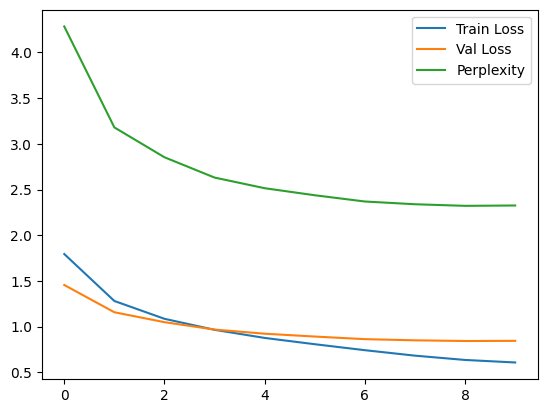

In [37]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(pps, label="Perplexity")
plt.legend()
plt.show()

# Test

In [31]:
def ids2sentence(ids, vocab_map) -> str:
  tokens = []
  for i in ids:
    if i not in [EN_SOS_ID, EN_EOS_ID, EN_PAD_ID]:
      tokens.append(vocab_map[str(i)])
  return " ".join(tokens)

In [39]:
!pip install torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 re

In [40]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/NLP/Transformer_5_epoch.pt"))

In [41]:
test_loader = DataLoader(test_dataset, batch_size=config_dict['batch_size'], collate_fn=collate_fn, shuffle=False)


In [42]:
def process_preds_target(preds, target):
  processed_dict = {}

  for pred, tar in zip(preds, target):
    if pred not in processed_dict:
      processed_dict[pred] = [tar]
    else:
      processed_dict[pred].append(tar)

  return list(processed_dict.keys()), list(processed_dict.values())


In [43]:
from torchmetrics.text import BLEUScore

def test(model, test_loader, n_gram=4, max_generated_token_len=94):
  bleu_metric = BLEUScore(n_gram=n_gram)

  model = model.to(device)
  model.eval()
  with torch.no_grad():
    src_embed = model.src_embed
    tgt_embed = model.tgt_embed
    encoder = model.encoder
    decoder = model.decoder
    generator = model.generator

    all_source = []
    all_preds = []
    all_target = []
    for vi, _, en_out in tqdm(test_loader):
      # Generate source padding mask for the encoder
      src_padding_mask = generate_padding_mask(vi, VI_PAD_ID)

      enc_o = encoder(src_embed(vi), src_padding_mask=src_padding_mask)
      batch_size = vi.shape[0]
      decoder_input = torch.full((batch_size, 1), EN_SOS_ID, device=device)

      batch_outputs = [[] for _ in range(batch_size)]
      is_finished = [False] * batch_size  # track EOS
      for _ in range(max_generated_token_len):
        # Pass all relevant masks to the decoder
        dec_o = decoder(tgt_embed(decoder_input), enc_o, memory_padding_mask=src_padding_mask)
        output = generator(dec_o)  # (batch_sz, seq_len, vocab_sz)

        next_token_id = torch.argmax(output[:, -1, :], dim=-1)  # (batch_sz)
        next_token = next_token_id.unsqueeze(1)

        decoder_input = torch.cat([decoder_input, next_token], dim=-1)

        last_tokens = next_token_id.tolist()
        for i in range(batch_size):
          if not is_finished[i]:
            last_token = last_tokens[i]
            if last_token == EN_EOS_ID:
              is_finished[i] = True
            else:
              batch_outputs[i].append(last_token)

        # Stop early if all sentences finished
        if all(is_finished):
          break

      all_preds.extend(batch_outputs)
      all_target.extend(en_out.tolist())
      all_source.extend(vi.tolist())
      # check 1 batch
      # break
    sources = [ids2sentence(vi, vi_id2token) for vi in all_source]
    preds = [ids2sentence(pred, en_id2token) for pred in all_preds]
    target = [ids2sentence(tar, en_id2token) for tar in all_target]

    preds, target = process_preds_target(preds, target)
    for i in range(5):
      print(f" - Origin: {sources[i]} \nPred: {preds[i]} \nTarget: {target[i]}")

    score = bleu_metric(preds, target)
    print(f"BLEU Score: {score.item()}")

test(model, test_loader)

100%|██████████| 49/49 [00:10<00:00,  4.60it/s]


 - Origin: họ bán các chứng chỉ bảo mật </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Pred: they sell their security evidence . 
Target: ['they sell certificates .']
 - Origin: ở đất nước của chúng ta , tại những bang miền nam lâu đời người ta vẫn thực thi án tử hình bạn có khả năng bị kết án tử hình cao gấp 11 lần nếu nạn nhân là người da trắng so với nạn nhân là người da đen và gấp 22 lần nếu bị đơn là người da đen còn nạn nhân là người da trắng chính những tiểu bang này đã chôn biết bao thi thể của người bị xử tử </s> 
Pred: in our country , in the south states , who l

In [ ]:
class PredDataset(Dataset):
  def __init__(self, vi):
    self.vi = [tokens + [VI_EOS_ID] for tokens in vi]

  def __len__(self):
    return len(self.vi)

  def __getitem__(self, idx):
    return torch.tensor(self.vi[idx])

def pred_collate_fn(batch):
  vi_ts = pad_sequence(batch, batch_first=True, padding_value=VI_PAD_ID)
  return vi_ts.to(device)



In [42]:
def predict(model, sentences, max_generated_token_len=5, beam_size=5):
  vi = [[vi_token2id.get(token, VI_UNK_ID) for token in sentence.split()] for sentence in sentences]

  model = model.to(device)
  model.eval()
  with torch.no_grad():
    src_embed = model.src_embed
    tgt_embed = model.tgt_embed
    encoder = model.encoder
    decoder = model.decoder
    generator = model.generator

    all_best_preds = [] # List to store the best prediction for each sentence
    all_sources_in_batch_order = [] # To store original source sentences in batch order

    pred_dataset = PredDataset(vi)
    loader = DataLoader(pred_dataset, batch_size=config_dict['batch_size'], collate_fn=pred_collate_fn)

    sentence_idx = 0
    for vi_batch in tqdm(loader):
      src_padding_mask = generate_padding_mask(vi_batch, VI_PAD_ID)
      enc_o = encoder(src_embed(vi_batch), src_padding_mask=src_padding_mask)

      batch_size = vi_batch.shape[0]

      for i in range(batch_size):
        # Store the original source sentence for this item in the batch
        all_sources_in_batch_order.append(sentences[sentence_idx])

        encoder_out = enc_o[i].unsqueeze(0)  # (1, seq_len, d_model)
        enc_pad_mask_i = src_padding_mask[i].unsqueeze(0)

        beams = [(torch.tensor([EN_SOS_ID], device=device), 0.0, False)] # (sequence, score, finished)

        for _ in range(max_generated_token_len):
          candidates = []

          for seq, score, finished in beams:
            if finished:
              candidates.append((seq, score, True))
              continue

            seq_input = seq.unsqueeze(0)  # (1, seq_len)
            # Generate target mask for the decoder (look-ahead mask)
            tgt_seq_len = seq_input.shape[1]
            tgt_mask = generate_subsequence_mask(tgt_seq_len).to(device)

            # Generate target padding mask (not needed here as beam sequences don't have pads until final processing)
            # For simplicity, we can create a dummy one or ensure it doesn't interfere

            dec_out = decoder(tgt_embed(seq_input), encoder_out, target_mask=tgt_mask, memory_padding_mask=enc_pad_mask_i)
            logits = generator(dec_out)

            # last token
            log_probs = torch.log_softmax(logits[:, -1, :], dim=-1).squeeze(0)  # (vocab_len)

            # topk
            topk_log_probs, topk_ids = torch.topk(log_probs, beam_size)
            for log_p, token_id in zip(topk_log_probs, topk_ids):
              new_seq = torch.cat([seq, torch.tensor([token_id], device=device)])
              new_score = score + log_p.item()
              new_finished = token_id == EN_EOS_ID
              candidates.append((new_seq, new_score, new_finished))

          # sorted by score, topk
          candidates = sorted(candidates, key=lambda x: x[1]/len(x[0]), reverse=True) # Normalize score by length
          beams = candidates[:beam_size]

          # all finished = True
          if all(f for _, _, f in beams):
              break

        # After beam search for one sentence, select the best prediction
        best_seq_tokens = beams[0][0].cpu().tolist()
        best_pred_sentence = ids2sentence(best_seq_tokens, en_id2token)
        all_best_preds.append(best_pred_sentence)
        sentence_idx += 1

    return all_sources_in_batch_order, all_best_preds

In [47]:
from torchmetrics.text import BLEUScore

# Run prediction on the entire test set
source_sentences, predicted_sentences = predict(model, test_df['vi'].tolist(), max_generated_token_len=94, beam_size=5)

# Prepare target sentences from test_df['en_token']
target_token_ids = test_df['en_token'].tolist()
target_sentences = []
for tokens in target_token_ids:
    # ids2sentence removes SOS/EOS/PAD, BLEUScore expects reference sentences as lists of strings.
    # So, we convert each target sentence to a list containing one string, as required by torchmetrics.
    target_sentences.append([ids2sentence(tokens, en_id2token)])

# Initialize BLEU metric
bleu_metric = BLEUScore(n_gram=4)

# Calculate BLEU score
score = bleu_metric(predicted_sentences, target_sentences)

print(f"BLEU Score: {score.item():.4f}")

print("\n--- Sample Translations ---")
for i in range(5):
    print(f"Original (vi): {source_sentences[i]}")
    print(f"Predicted (en): {predicted_sentences[i]}")
    print(f"Target (en): {target_sentences[i][0]}") # target_sentences is list of lists, so access [0]
    print("\n")

100%|██████████| 49/49 [05:56<00:00,  7.28s/it]


BLEU Score: 0.2580

--- Sample Translations ---
Original (vi): họ bán các chứng chỉ bảo mật
Predicted (en): they sell their security evidence .
Target (en): they sell certificates .


Original (vi): ở đất nước của chúng ta , tại những bang miền nam lâu đời người ta vẫn thực thi án tử hình bạn có khả năng bị kết án tử hình cao gấp 11 lần nếu nạn nhân là người da trắng so với nạn nhân là người da đen và gấp 22 lần nếu bị đơn là người da đen còn nạn nhân là người da trắng chính những tiểu bang này đã chôn biết bao thi thể của người bị xử tử
Predicted (en): in our country , in the secular states , in the secular states , people still do the death sentence , you have the ability to get <unk> death twice as if the victim is black and 22 times as seven times as black or six times as the black and the black person is the white of those states who know how to behave .
Target (en): and yet , in this country , in the states of the old south , we execute people -- where you 're 11 times more likel

In [ ]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata

# Retrieve the API key from Colab secrets
genai.configure(api_key='GEMINI_KEY')

# Initialize the Generative Model
gemini_model = genai.GenerativeModel('gemini-2.5-flash-lite') # Using a capable model for evaluation
print("Gemini API configured successfully.")

In [ ]:
import re
from tqdm import tqdm
from time import sleep
def create_llm_judge_prompt(source, predicted, reference):
    return f"""You are an expert in evaluating machine translations. You will be provided with a Source sentence, a Machine Translation (Predicted), and a Human Reference Translation. 
    
Your task is to rate the quality of the Machine Translation on a scale of 1 to 10.

Scale Definition:
1: Nonsense - No meaning is conveyed; hallucination or completely wrong.
2: Very Poor - Severe inaccuracies; barely understandable.
3: Poor - Conveying some isolated meaning, but grammatically broken or very confusing.
4: Below Average - The gist is there, but with critical errors in accuracy or grammar.
5: Average - Understandable, but awkward phrasing or noticeable errors.
6: Above Average - Mostly correct meaning, but lacks fluency or has minor grammatical slips.
7: Good - Accurate and readable, but may not sound completely native.
8: Very Good - Fluent and accurate; only very minor stylistic imperfections.
9: Excellent - Near-perfect translation, preserving nuance and tone.
10: Perfect - Indistinguishable from a professional human translator.

Please provide your rating as a single integer (1-10) at the end of your response.
Do not include any other text besides your justification and the final score.

Source: {source}
Predicted: {predicted}
Reference: {reference}
Rating:
"""

def evaluate_with_gemini_batch(sources, predicted_sentences, target_sentences, model, batch_size=10):
    eval_scores = []
    
    # Iterate through data in batches
    for i in tqdm(range(0, len(sources), batch_size), desc="Evaluating with Gemini"):
        sleep(1)
        batch_sources = sources[i:i + batch_size]
        batch_predicted = predicted_sentences[i:i + batch_size]
        batch_targets = target_sentences[i:i + batch_size]

        prompts = [
            create_llm_judge_prompt(src, pred, tar[0]) 
            for src, pred, tar in zip(batch_sources, batch_predicted, batch_targets)
        ]

        try:
            # Note: Ensure your model object supports list input for 'prompts'. 
            # If using standard Google GenAI SDK, you might need to loop individually 
            # or use specific batching API methods.
            responses = model.generate_content(prompts, generation_config={'temperature': 0})
            
            # Handle case where response might be a single object vs list based on SDK version
            if not isinstance(responses, list) and hasattr(responses, 'text'):
                 # Fallback if API returns single response for single prompt
                 responses = [responses] 

            for res in responses:
                try:
                    text = res.text.strip()
                    # REGEX UPDATE: Looks for 10 or 1-9
                    matches = re.findall(r'\b(10|[1-9])\b', text)
                    
                    if matches:
                        # Get the last number found in the response
                        eval_scores.append(int(matches[-1]))
                    else:
                        eval_scores.append(None)
                except ValueError:
                    # Handle cases where safety filters block the text
                    eval_scores.append(None)
                    
        except Exception as e:
            print(f"Error during batch generation: {e}")
            eval_scores.extend([None] * len(batch_sources))

    return eval_scores 

In [ ]:
if 'gemini_model' in locals():
    sample_sources = source_sentences
    sample_predicted = predicted_sentences
    sample_targets = target_sentences

    gemini_scores = evaluate_with_gemini_batch(
        sample_sources,
        sample_predicted,
        sample_targets,
        gemini_model,
        batch_size=10
    )
    print(f"\nGemini Evaluation Scores for sample: {gemini_scores}")

    # Calculate average score (ignoring Nones)
    valid_scores = [score for score in gemini_scores if score is not None]
    if valid_scores:
        average_gemini_score = sum(valid_scores) / len(valid_scores)
        print(f"Average Gemini Score for sample: {average_gemini_score:.2f}")
    else:
        print("No valid scores obtained from Gemini evaluation.")
else:
    print("Gemini model not initialized. Please run the setup cells first.")

# Load model

In [40]:
checkpoint = torch.load("../models/model_statedict-23-12-2025_15h06m.pth", map_location="cpu")

model.load_state_dict(checkpoint)

<All keys matched successfully>

In [46]:
predict(model, ['tôi bị điên'], max_generated_token_len=5, beam_size=1)

100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


(['tôi bị điên'], ['i was crazy .'])